# Predicting Stroke Prediction

The file healthcare-dataset-stroke-data.csv_ contains information from the World Health Organization (WHO). It is said that stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

In [ ]:
# import required packages
%matplotlib inline
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from dmba import classificationSummary
# Load libraries
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from matplotlib import pyplot as plt

In [ ]:
# set path for data file repository
DATA = Path('.')

In [ ]:
# load the data
stroke_df = pd.read_csv(DATA / 'healthcare-dataset-stroke-data.csv')
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# dummies
stroke_df.loc[stroke_df.gender == 'Male' , 'gender'] = 1
stroke_df.loc[stroke_df.gender == 'Female' , 'gender'] = 0
stroke_df
stroke_df.loc[stroke_df.Residence_type == 'Urban' , 'Residence_type'] = 1
stroke_df.loc[stroke_df.Residence_type == 'Rural' , 'Residence_type'] = 0
stroke_df
stroke_df.loc[stroke_df.smoking_status == 'smokes' , 'smoking_status'] = 2
stroke_df.loc[stroke_df.smoking_status == 'formerly smoked' , 'smoking_status'] = 1
stroke_df.loc[stroke_df.smoking_status == 'never smoked' , 'smoking_status'] = 0
stroke_df = stroke_df[stroke_df.smoking_status != 'Unknown']
stroke_df = stroke_df.dropna()
stroke_df
# convert variables to categorical data type
stroke_df['gender'] = stroke_df['gender'].astype('category')
pd.get_dummies(stroke_df, prefix_sep='_', drop_first=False)
stroke_df['Residence_type'] = stroke_df['Residence_type'].astype('category')
pd.get_dummies(stroke_df, prefix_sep='_', drop_first=False)
stroke_df['heart_disease'] = stroke_df['heart_disease'].astype('category')
pd.get_dummies(stroke_df, prefix_sep='_', drop_first=False)
stroke_df['hypertension'] = stroke_df['hypertension'].astype('category')
pd.get_dummies(stroke_df, prefix_sep='_', drop_first=False)

#bin labels
age_bins = ['=<20', '21-40', '41-60', '>=61']
glucose_bins1 = ['55-82', '83-109', '110-136', '137-163', '164-190', '191-218', '219-245', '>=246' ]
bmi_bins = ['10-32', '33-53', '54-75', '>=76']

# bin variables into bins and convert to categorical data type
stroke_df['binned_age'] = pd.cut(stroke_df.age, 4, labels=age_bins)
stroke_df['binned_age'] = stroke_df['binned_age'].astype('category')
stroke_df['binned_glucose'] = pd.cut(stroke_df.avg_glucose_level, 8, labels=glucose_bins1)
stroke_df['binned_glucose'] = stroke_df['binned_glucose'].astype('category')
stroke_df['binned_bmi'] = pd.cut(stroke_df.bmi, 4, labels=bmi_bins)
stroke_df['binned_bmi'] = stroke_df['binned_bmi'].astype('category')
# select only those variables which can be used for predicting the outcome
columns = list(stroke_df.columns)
columns.remove('id')
columns.remove('stroke')
columns.remove('ever_married')
columns.remove('work_type')
columns.remove('age')
#columns.remove('binned_age')
columns.remove('bmi')
columns.remove('smoking_status')
columns.remove('avg_glucose_level')
predictors_df = stroke_df[columns]
predictors_df.head()

,gender,hypertension,heart_disease,Residence_type,binned_age,binned_glucose,binned_bmi
0,1,0,1,1,>=61,219-245,33-53
2,1,0,1,0,>=61,83-109,33-53
3,0,0,0,1,41-60,164-190,33-53
4,0,1,0,0,>=61,164-190,10-32
5,1,0,0,1,>=61,164-190,10-32


In [ ]:
# create dummies for categorical variables
predictors_df = pd.get_dummies(predictors_df, prefix_sep='_')
predictors_list = list(predictors_df.columns)
predictors_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3426 entries, 0 to 5108
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   gender_0                3426 non-null   uint8
 1   gender_1                3426 non-null   uint8
 2   gender_Other            3426 non-null   uint8
 3   hypertension_0          3426 non-null   uint8
 4   hypertension_1          3426 non-null   uint8
 5   heart_disease_0         3426 non-null   uint8
 6   heart_disease_1         3426 non-null   uint8
 7   Residence_type_0        3426 non-null   uint8
 8   Residence_type_1        3426 non-null   uint8
 9   binned_age_=<20         3426 non-null   uint8
 10  binned_age_21-40        3426 non-null   uint8
 11  binned_age_41-60        3426 non-null   uint8
 12  binned_age_>=61         3426 non-null   uint8
 13  binned_glucose_55-82    3426 non-null   uint8
 14  binned_glucose_83-109   3426 non-null   uint8
 15  binned_glucose_110-13

In [ ]:
# partition the data into training (60%) and validation (40%) sets
X = predictors_df
y = stroke_df['stroke']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X.head()

,gender_0,gender_1,gender_Other,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,Residence_type_0,Residence_type_1,binned_age_=<20,...,binned_glucose_110-136,binned_glucose_137-163,binned_glucose_164-190,binned_glucose_191-218,binned_glucose_219-245,binned_glucose_>=246,binned_bmi_10-32,binned_bmi_33-53,binned_bmi_54-75,binned_bmi_>=76
361,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4238,1,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1797,1,0,0,1,0,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
2975,1,0,0,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2257,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0


5


[Text(200.88000000000002, 181.2, 'X[12] <= 0.5\ngini = 0.103\nsamples = 2055\nvalue = [1943, 112]'),
 Text(133.92000000000002, 108.72, 'X[11] <= 0.5\ngini = 0.052\nsamples = 1573\nvalue = [1531, 42]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.009\nsamples = 935\nvalue = [931, 4]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.112\nsamples = 638\nvalue = [600, 38]'),
 Text(267.84000000000003, 108.72, 'gini = 0.248\nsamples = 482\nvalue = [412, 70]')]

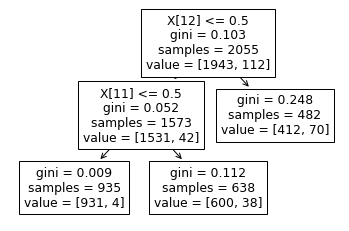

In [ ]:
# fit the DT model and draw the tree
# use a tree with maximum depth 8 and minimum impurity decrease = 0.01
smallClassTree = DecisionTreeClassifier(max_depth = 5, min_samples_split=10, min_impurity_decrease=0.001)
smallClassTree.fit(train_X, train_y)

#print node count and plot tree
print(smallClassTree.tree_.node_count)
plot_tree(smallClassTree)

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(train_X, train_y)
y_pred = clf.predict(valid_X)
print("Accuracy:",metrics.accuracy_score(valid_y, y_pred))

Accuracy: 0.9438366156090445


In [ ]:
# partition the data into a stratified training and testing split on the decision variable

X1 = predictors_df
y1 = stroke_df['stroke']
train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.4, random_state=1, stratify = y1)

327


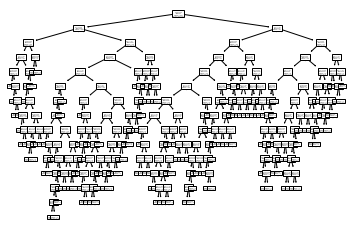

In [ ]:
# full-grown tree
fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X1, train_y1)

print(fullClassTree.tree_.node_count)
plot_tree(fullClassTree);

1


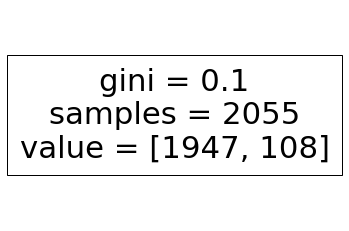

In [ ]:
# small tree
ClassTree = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_impurity_decrease=0.01)
ClassTree.fit(train_X1, train_y1)

print(ClassTree.tree_.node_count)
plot_tree(ClassTree);

In [ ]:
# predictive power of full-tree on training set
pred_v = fullClassTree.predict(train_X1)

# confusion matrix for training set
classificationSummary(train_y1, pred_v)

Confusion Matrix (Accuracy 0.9591)

       Prediction
Actual    0    1
     0 1944    3
     1   81   27


In [ ]:
# predictive power of full-tree on validation set
pred_v = fullClassTree.predict(valid_X1)

# confusion matrix for validation set
classificationSummary(valid_y1, pred_v)

Confusion Matrix (Accuracy 0.9358)

       Prediction
Actual    0    1
     0 1281   18
     1   70    2


In [ ]:
# predictive power of small tree on training set
pred_v = ClassTree.predict(train_X1)

# confusion matrix for training set
classificationSummary(train_y1, pred_v)

Confusion Matrix (Accuracy 0.9474)

       Prediction
Actual    0    1
     0 1947    0
     1  108    0


In [ ]:
# predictive power of small tree on validation set
pred_v = ClassTree.predict(valid_X1)

# confusion matrix for validation set
classificationSummary(valid_y1, pred_v)

Confusion Matrix (Accuracy 0.9475)

       Prediction
Actual    0    1
     0 1299    0
     1   72    0


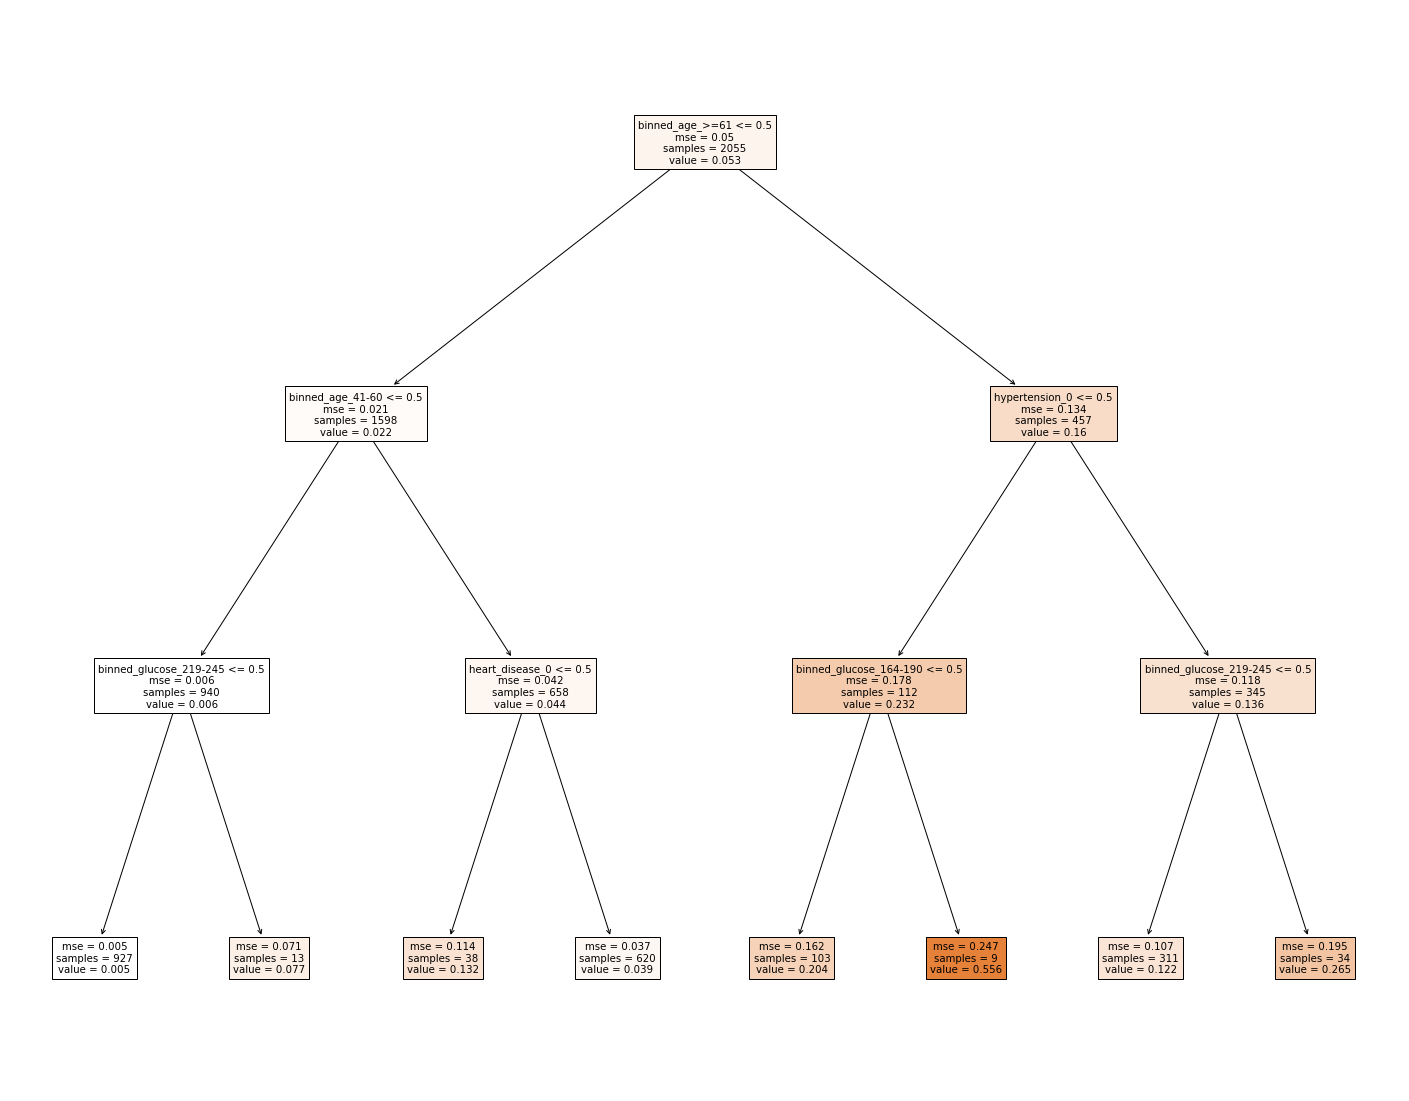

In [ ]:
# train decision tree regressor

regr = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=1234)
model = regr.fit(train_X1, train_y1)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr, filled=True, feature_names = predictors_list)


In [ ]:
# partition the data under nonstratified random training testing split
X2 = predictors_df
y2 = stroke_df['stroke']
train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X2, y2, test_size=0.4, random_state=1)

In [ ]:
# train decison tree regressor under radomized training testing split

#regr = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=1234)
#model = regr.fit(train_X2, train_y2)
#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(regr, filled=True, feature_names = predictors_list)